In [1]:
import geopandas as gpd
gdf = gpd.read_file('/home/yamanishi/project/trip_recommend/model/popularity_final/data/japan_ver84/japan_ver84/japan_ver84.shp')
print(len(gdf))
gdf.head()

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/pycaret/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


1907


,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,Shape_Area,geometry
0,01101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",239944,146024,0.542590,0.005128,"POLYGON ((141.34233 43.06682, 141.35520 43.068..."
1,01102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",286054,153908,0.567773,0.007031,"POLYGON ((141.40839 43.18395, 141.40427 43.182..."
2,01103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",262298,144421,0.397203,0.006289,"POLYGON ((141.44698 43.15513, 141.44860 43.153..."
3,01104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",214050,124710,0.308211,0.003815,"POLYGON ((141.46569 43.10000, 141.46812 43.097..."
4,01105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",224435,129875,0.428316,0.005101,"POLYGON ((141.38479 43.04660, 141.38558 43.047..."


import

In [2]:
import os

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
import shapely
from tqdm import tqdm
from collections import defaultdict
import geopandas as gpd
from pysal.lib import weights
from splot.esda import lisa_cluster
from matplotlib.pyplot import Axes
from tqdm import tqdm
tqdm.pandas()

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/pycaret/lib/python3.7/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [5]:
df_exp = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
tfidf_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_words.npy')
tfidf_topk_index = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_topk_index.npy')
tfidf_top_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')

In [6]:
d = defaultdict(list)
for index in tqdm(range(len(df_exp))):
    lat = df_exp.loc[index, 'latitude']
    lon = df_exp.loc[index, 'longitude']
    count = [0]*len(gdf)
    contain=gdf['geometry'].contains(shapely.geometry.point.Point(lon, lat))
    spot_name = df_exp.loc[index, 'spot_name']
    try:
        city_index = list(contain.values).index(True)
        d[city_index].append(index)
    except ValueError:
        continue

  5%|▌         | 2297/42852 [00:02<00:51, 781.18it/s]


KeyboardInterrupt: 

In [ ]:
with open('/home/yamanishi/project/trip_recommend/model/popularity_final/data/district_to_spot.pkl', 'wb') as f:
    pickle.dump(d, f)

In [3]:
import pickle
with open('/home/yamanishi/project/trip_recommend/model/popularity_final/data/district_to_spot.pkl', 'rb') as f:
    district_to_spot = pickle.load(f)

In [6]:
from shapely.geometry import Point
def point_from_lon_lat(df):
    return Point(df['longitude'], df['latitude'])

df_exp['geometry'] = df_exp.progress_apply(point_from_lon_lat, axis=1)

100%|██████████| 42852/42852 [00:01<00:00, 25767.34it/s]


Pycaret & Shap

In [6]:
district_spot_num = [0]*len(gdf)
for district, spots in district_to_spot.items():
    district_spot_num[district] = len(spots)

gdf['spot_num'] = gpd.GeoSeries(district_spot_num)

spot_reviewcount = {i:review_count for i, review_count in enumerate(df_exp['review_count'])}
district_review_count = [0]*len(gdf)
for district, spots in district_to_spot.items():
    for spot in spots:
        district_review_count[district] += spot_reviewcount[spot]
gdf['review_count'] = gpd.GeoSeries(district_review_count)

import math
district_review_count_log = [0]*len(gdf)
for district, spots in district_to_spot.items():
    for spot in spots:
        district_review_count_log[district] += math.log10(spot_reviewcount[spot])
gdf['review_count_log'] = gpd.GeoSeries(district_review_count_log)
gdf['log_review_count'] = np.log10(gdf['review_count'])

In [7]:
with open('/home/yamanishi/project/trip_recommend/data/jalan/graph/category_index.pkl', 'rb') as f:
    category_index = pickle.load(f)
category = category_index.keys()
category = list(category)
category_dict = {k:[0]*len(gdf) for k in category}
spot_jenre = {spot:jenre for spot, jenre in enumerate(df_exp['jenre'])}
for district, spots in district_to_spot.items():
    for spot in spots:
        jenre = spot_jenre[spot]
        for j in jenre.split(','):
            category_dict[j][district]+=1

In [8]:
for c,v in category_dict.items():
    gdf[c] = np.array(v)

In [9]:
gdf.head()

,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,...,梅干し作り,ゴルフ・ゴルフ場,田舎暮らし体験,宝探し（トレジャーハント）,洋食,洋食全般,草木染め,三味線体験,原付・バイクレンタル,収穫
0,01101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",239944,146024,0.542590,...,0,0,0,0,0,0,0,0,0,0
1,01102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",286054,153908,0.567773,...,0,0,0,0,0,0,0,0,0,0
2,01103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",262298,144421,0.397203,...,0,0,0,0,0,0,0,0,0,0
3,01104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",214050,124710,0.308211,...,0,0,0,0,0,0,0,0,0,0
4,01105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",224435,129875,0.428316,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from pycaret.regression import *
seed = 42
exp1 = setup(data = gdf, 
             target='log_review_count',
             normalize=True,             
             ignore_features=['JCODE', 'KEN', 'SICHO', 'GUN', 'SEIREI', 'SIKUCHOSON', 'CITY_ENG',
            'P_NUM', 'H_NUM', 'Shape_Leng', 'Shape_Area', 'geometry', 'spot_num',
            'review_count_log', 'review_count'],
             session_id=seed)

classifiers = compare_models(n_select=5, budget_time=100)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.2659,0.1147,0.3376,0.7877,0.1019,0.1151,12.5730
lightgbm,Light Gradient Boosting Machine,0.2736,0.1219,0.3484,0.7748,0.1035,0.1156,0.1100
gbr,Gradient Boosting Regressor,0.2736,0.1222,0.3486,0.7742,0.1066,0.1213,0.5060
rf,Random Forest Regressor,0.2853,0.1347,0.3659,0.7503,0.1094,0.1204,0.5580
et,Extra Trees Regressor,0.2895,0.1377,0.3695,0.7452,0.1104,0.1219,0.6930
xgboost,Extreme Gradient Boosting,0.2975,0.1407,0.3746,0.7398,0.1111,0.1262,1.7180
ada,AdaBoost Regressor,0.3093,0.1525,0.3897,0.7175,0.1171,0.1342,0.4180
br,Bayesian Ridge,0.3236,0.1667,0.4073,0.6926,0.1242,0.1459,0.5220
omp,Orthogonal Matching Pursuit,0.3564,0.2123,0.4598,0.6085,0.1311,0.1520,0.0430
huber,Huber Regressor,0.3786,0.2353,0.4835,0.5641,0.1363,0.1579,0.4950


In [11]:
tuned_models = [tune_model(clf) for clf in classifiers]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3608,0.2054,0.4532,0.6773,0.1434,0.1770
1,0.3498,0.1742,0.4173,0.6722,0.1200,0.1439
2,0.3644,0.2126,0.4611,0.6286,0.1430,0.1749
3,0.3666,0.2264,0.4758,0.6059,0.1400,0.1579
4,0.3341,0.1887,0.4343,0.6652,0.1244,0.1379
5,0.3366,0.1807,0.4251,0.6520,0.1329,0.1590
6,0.3137,0.1533,0.3916,0.6596,0.1141,0.1308
7,0.3463,0.1920,0.4381,0.6415,0.1378,0.1644
8,0.3480,0.1879,0.4335,0.5998,0.1385,0.1718


In [12]:
gdf.columns

Index(['JCODE', 'KEN', 'SICHO', 'GUN', 'SEIREI', 'SIKUCHOSON', 'CITY_ENG',
       'P_NUM', 'H_NUM', 'Shape_Leng',
       ...
       '梅干し作り', 'ゴルフ・ゴルフ場', '田舎暮らし体験', '宝探し（トレジャーハント）', '洋食', '洋食全般', '草木染め',
       '三味線体験', '原付・バイクレンタル', '収穫'],
      dtype='object', length=306)

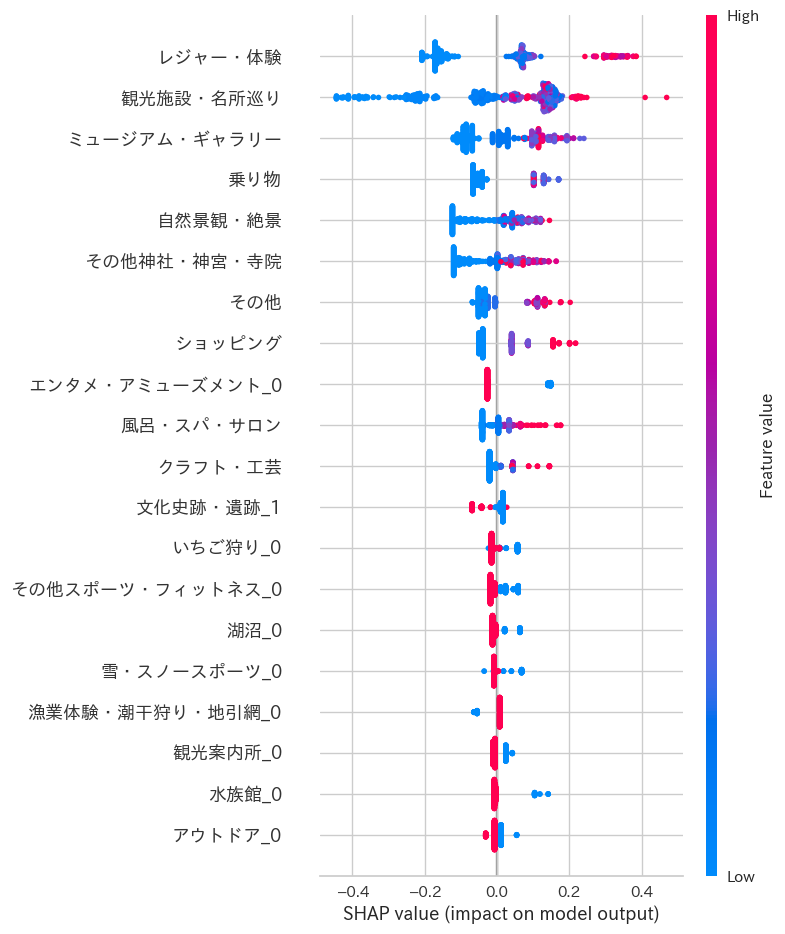

In [13]:
import matplotlib.pyplot as plt
import japanize_matplotlib
interpret_model(tuned_models[0])

In [14]:
gdf.head()

,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,...,梅干し作り,ゴルフ・ゴルフ場,田舎暮らし体験,宝探し（トレジャーハント）,洋食,洋食全般,草木染め,三味線体験,原付・バイクレンタル,収穫
0,01101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",239944,146024,0.542590,...,0,0,0,0,0,0,0,0,0,0
1,01102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",286054,153908,0.567773,...,0,0,0,0,0,0,0,0,0,0
2,01103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",262298,144421,0.397203,...,0,0,0,0,0,0,0,0,0,0
3,01104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",214050,124710,0.308211,...,0,0,0,0,0,0,0,0,0,0
4,01105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",224435,129875,0.428316,...,0,0,0,0,0,0,0,0,0,0


pycarat+emoion

In [15]:
df_exp = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
tfidf_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')
tfidf_topk_index = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_topk_index.npy')
tfidf_top_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')

In [16]:
df_review = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/review/review_all_period_.csv')

In [17]:
emotion_df = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/emotion.csv')

In [18]:
import geopandas as gpd
gdf = gpd.read_file('/home/yamanishi/project/trip_recommend/model/popularity_final/data/japan_ver84/japan_ver84/japan_ver84.shp')
gdf.head()

,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,Shape_Area,geometry
0,01101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",239944,146024,0.542590,0.005128,"POLYGON ((141.34233 43.06682, 141.35520 43.068..."
1,01102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",286054,153908,0.567773,0.007031,"POLYGON ((141.40839 43.18395, 141.40427 43.182..."
2,01103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",262298,144421,0.397203,0.006289,"POLYGON ((141.44698 43.15513, 141.44860 43.153..."
3,01104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",214050,124710,0.308211,0.003815,"POLYGON ((141.46569 43.10000, 141.46812 43.097..."
4,01105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",224435,129875,0.428316,0.005101,"POLYGON ((141.38479 43.04660, 141.38558 43.047..."


In [19]:
import pickle
with open('/home/yamanishi/project/trip_recommend/model/popularity_final/data/district_to_spot.pkl', 'rb') as f:
    district_to_spot = pickle.load(f)
id_spot = {id:spot for id, spot in enumerate(df_exp['spot_name'])}
id_district = {}
for d, s in district_to_spot.items():
    for spot in s:
        id_district[spot] = d
spot_district= {id_spot[id]: district for id, district in id_district.items()}

In [20]:
from collections import defaultdict
from tqdm import tqdm
district_emotion = defaultdict(lambda:defaultdict(int))
for emotion in emotion_df.columns[1:]:
    for s, em in tqdm(zip(df_review['spot'], emotion_df[emotion])):
        if s in spot_district:
            d = spot_district[s]
            district_emotion[d][emotion]+=len(em)
        

3565959it [00:04, 727387.28it/s]
3565959it [00:05, 709265.65it/s] 
3565959it [00:05, 649125.69it/s]
3565959it [00:06, 561631.66it/s]
3565959it [00:05, 602444.16it/s]
3565959it [00:06, 562690.81it/s]
3565959it [00:05, 622784.79it/s]
3565959it [00:05, 630981.45it/s]
3565959it [00:06, 553437.30it/s]
3565959it [00:06, 581708.59it/s]


In [21]:
district_spot_num = [0]*len(gdf)
for district, spots in district_to_spot.items():
    district_spot_num[district] = len(spots)

gdf['spot_num'] = gpd.GeoSeries(district_spot_num)

spot_reviewcount = {i:review_count for i, review_count in enumerate(df_exp['review_count'])}
district_review_count = [0]*len(gdf)
for district, spots in district_to_spot.items():
    for spot in spots:
        district_review_count[district] += spot_reviewcount[spot]
gdf['review_count'] = gpd.GeoSeries(district_review_count)

import math
district_review_count_log = [0]*len(gdf)
for district, spots in district_to_spot.items():
    for spot in spots:
        district_review_count_log[district] += math.log10(spot_reviewcount[spot])
gdf['review_count_log'] = gpd.GeoSeries(district_review_count_log)
gdf['log_review_count'] = np.log10(gdf['review_count'])

In [22]:
for d, emotions in district_emotion.items():
    for emotion, emotion_count in emotions.items():
        gdf.loc[d, emotion] = emotion_count

In [23]:
category = gdf.iloc[:, 16:].values
norm_cat = category/(np.sum(category, axis=1).reshape(-1,1)+1e-6)
gdf.iloc[:, 16:] = norm_cat
gdf.head()
sum(gdf.iloc[1, 16:])

0.9999999999820909

In [24]:
from pycaret.regression import *
seed = 42
exp1 = setup(data = gdf, 
             target='log_review_count',
             normalize=False,             
             ignore_features=['JCODE', 'KEN', 'SICHO', 'GUN', 'SEIREI', 'SIKUCHOSON', 'CITY_ENG',
            'P_NUM', 'H_NUM', 'Shape_Leng', 'Shape_Area', 'geometry', 'spot_num',
            'review_count_log', 'review_count'],
             session_id=seed)

classifiers = compare_models(n_select=5, budget_time=100)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:37:13
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
aware,Numeric
haji,Numeric
ikari,Numeric
iya,Numeric
kowa,Numeric
odoroki,Numeric
suki,Numeric
takaburi,Numeric
yasu,Numeric
yorokobi,Numeric


In [ ]:
tuned_models = [tune_model(clf) for clf in classifiers]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3739,0.2412,0.4911,0.6211,0.1374,0.1607
1,0.3738,0.2237,0.4730,0.5790,0.1258,0.1443
2,0.3859,0.2423,0.4922,0.5769,0.1417,0.1679
3,0.3916,0.2454,0.4954,0.5727,0.1356,0.1582
4,0.3556,0.2108,0.4591,0.6259,0.1198,0.1328
5,0.3870,0.2471,0.4971,0.5241,0.1413,0.1661
6,0.3729,0.2043,0.4520,0.5464,0.1213,0.1433
7,0.3964,0.2352,0.4850,0.5607,0.1402,0.1697
8,0.3785,0.2327,0.4824,0.5043,0.1447,0.1800


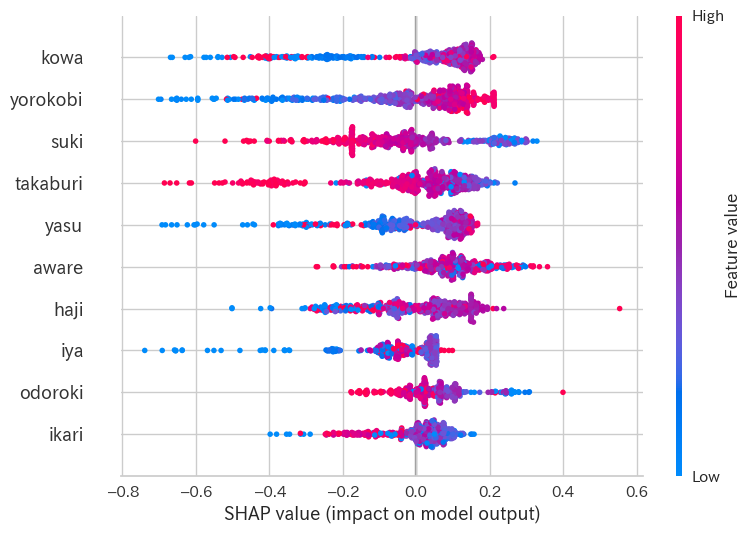

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
interpret_model(tuned_models[0])

pycaret + word

In [1]:
import geopandas as gpd
gdf = gpd.read_file('/home/yamanishi/project/trip_recommend/model/popularity_final/data/japan_ver84/japan_ver84/japan_ver84.shp')
gdf.head()

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/pycaret/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,Shape_Area,geometry
0,01101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",239944,146024,0.542590,0.005128,"POLYGON ((141.34233 43.06682, 141.35520 43.068..."
1,01102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",286054,153908,0.567773,0.007031,"POLYGON ((141.40839 43.18395, 141.40427 43.182..."
2,01103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",262298,144421,0.397203,0.006289,"POLYGON ((141.44698 43.15513, 141.44860 43.153..."
3,01104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",214050,124710,0.308211,0.003815,"POLYGON ((141.46569 43.10000, 141.46812 43.097..."
4,01105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",224435,129875,0.428316,0.005101,"POLYGON ((141.38479 43.04660, 141.38558 43.047..."


In [3]:
df_exp = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
tfidf_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_words.npy')
tfidf_topk_index = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_topk_index.npy')
tfidf_top_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')

In [4]:
import pickle
with open('/home/yamanishi/project/trip_recommend/model/popularity_final/data/district_to_spot.pkl', 'rb') as f:
    district_to_spot = pickle.load(f)
id_spot = {id:spot for id, spot in enumerate(df_exp['spot_name'])}
spot_district = {}
for d, s in district_to_spot.items():
    for spot in s:
        spot_district[spot] = d

In [5]:
from collections import defaultdict
district_words = defaultdict(lambda: defaultdict(int))
for i,words in enumerate(tfidf_words):
    for word in words:
        if i in spot_district:
            district_words[spot_district[i]][word]+=1
district_words

defaultdict(<function __main__.<lambda>()>,
            {10: defaultdict(int,
                         {'a': 43,
                          'e': 52,
                          'd': 17,
                          'r': 26,
                          'u': 13,
                          'f': 10,
                          't': 33,
                          'n': 36,
                          'o': 55,
                          'k': 11,
                          'b': 18,
                          'm': 9,
                          's': 26,
                          'p': 16,
                          'l': 27,
                          'g': 16,
                          'i': 36,
                          'w': 11,
                          'h': 12,
                          'c': 12,
                          'y': 7,
                          'v': 6,
                          'x': 2,
                          'j': 7,
                          'q': 1,
                          'ぁ': 1,
                   

In [6]:
district_spot_num = [0]*len(gdf)
for district, spots in district_to_spot.items():
    district_spot_num[district] = len(spots)

gdf['spot_num'] = gpd.GeoSeries(district_spot_num)

spot_reviewcount = {i:review_count for i, review_count in enumerate(df_exp['review_count'])}
district_review_count = [0]*len(gdf)
for district, spots in district_to_spot.items():
    for spot in spots:
        district_review_count[district] += spot_reviewcount[spot]
gdf['review_count'] = gpd.GeoSeries(district_review_count)

import math
district_review_count_log = [0]*len(gdf)
for district, spots in district_to_spot.items():
    for spot in spots:
        district_review_count_log[district] += math.log10(spot_reviewcount[spot])
gdf['review_count_log'] = gpd.GeoSeries(district_review_count_log)
gdf['log_review_count'] = np.log10(gdf['review_count'])

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/pycaret/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  """
/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/pycaret/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  if sys.path[0] == "":
/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/pycaret/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError in

In [7]:
from tqdm import tqdm
for district, words in tqdm(district_words.items()):
    for word, count in words.items():
        if count>=10:
            gdf.loc[district, word] = count 
gdf=gdf.fillna(0)
#category = gdf.iloc[:, 16:].values
#norm_cat = category/(np.sum(category, axis=1).reshape(-1,1)+1e-6)
#gdf.iloc[:, 16:] = norm_cat
#gdf.head()
#sum(gdf.iloc[1, 16:])

  0%|          | 0/1873 [00:00<?, ?it/s]/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/pycaret/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
100%|██████████| 1873/1873 [00:00<00:00, 5564.96it/s]


In [8]:
from pycaret.regression import *
seed = 42
exp1 = setup(data = gdf, 
             target='log_review_count',
             normalize=False,             
             ignore_features=['JCODE', 'KEN', 'SICHO', 'GUN', 'SEIREI', 'SIKUCHOSON', 'CITY_ENG',
            'P_NUM', 'H_NUM', 'Shape_Leng', 'Shape_Area', 'geometry', 'spot_num',
            'review_count_log', 'review_count'],
             session_id=seed)

classifiers = compare_models(n_select=5, budget_time=100)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.4599,0.3478,0.5890,0.3557,0.1769,0.2122,0.1630
rf,Random Forest Regressor,0.4621,0.3494,0.5905,0.3530,0.1772,0.2128,0.1550
catboost,CatBoost Regressor,0.4637,0.3563,0.5963,0.3413,0.1785,0.2151,1.7450
dt,Decision Tree Regressor,0.4701,0.3573,0.5972,0.3377,0.1785,0.2153,0.0140
xgboost,Extreme Gradient Boosting,0.4669,0.3617,0.6010,0.3311,0.1787,0.2155,0.2260
gbr,Gradient Boosting Regressor,0.4785,0.3744,0.6114,0.3077,0.1829,0.2234,0.0390
knn,K Neighbors Regressor,0.5002,0.3983,0.6299,0.2638,0.1848,0.2185,0.0250
br,Bayesian Ridge,0.4881,0.4040,0.6325,0.2573,0.1842,0.2257,0.0180
omp,Orthogonal Matching Pursuit,0.4996,0.4403,0.6581,0.1921,0.1884,0.2296,0.1390
lightgbm,Light Gradient Boosting Machine,0.5340,0.4617,0.6789,0.1496,0.1991,0.2454,0.0300


In [ ]:
tuned_models = [tune_model(clf) for clf in classifiers]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5214,0.4337,0.6585,0.3186,0.2026,0.2592
1,0.4615,0.3269,0.5717,0.3848,0.1642,0.1936
2,0.5173,0.4087,0.6393,0.2861,0.1941,0.2465
3,0.5465,0.4616,0.6794,0.1964,0.1963,0.2383
4,0.4721,0.3461,0.5883,0.3858,0.1702,0.2016
5,0.4809,0.3711,0.6092,0.2853,0.1868,0.2314
6,0.5221,0.4173,0.6460,0.0736,0.1812,0.2127
7,0.5114,0.3969,0.6300,0.2589,0.1925,0.2448
8,0.4959,0.3860,0.6213,0.1779,0.1949,0.2545


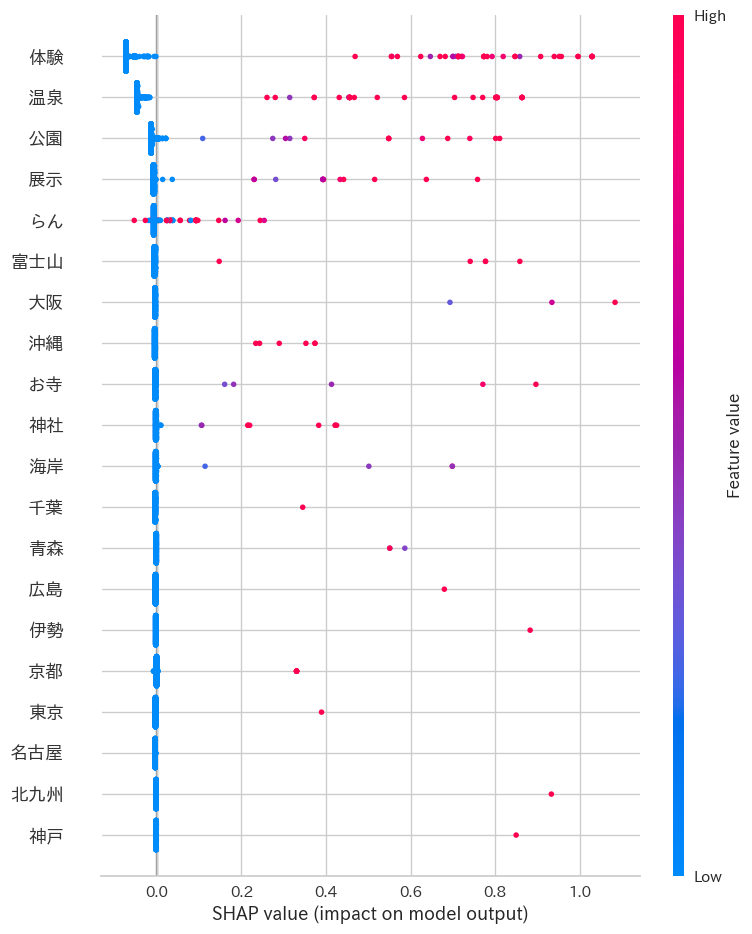

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
interpret_model(tuned_models[0])

In [ ]:
gdf=gdf.fillna(0)

In [ ]:
from matplotlib.pyplot import Axes
DEFAULT_CRS=4326
def create_choropleth_map(gdf: gpd.GeoDataFrame, target_col: str, draw_axes: Axes) -> Axes:
    gdf = gdf.to_crs(crs=DEFAULT_CRS)
    gdf.plot(
        column=target_col,
        cmap="viridis",
        scheme="quantiles",
        k=5,
        edgecolor="white",
        linewidth=0.0,
        alpha=0.75,
        legend=True,
        legend_kwds={"loc": 2},
        ax=draw_axes,
    )
    contextily.add_basemap(
        ax=draw_axes,
        crs=DEFAULT_CRS,
        source=contextily.providers.Stamen.TerrainBackground,
    )
    draw_axes.set_axis_off()

NameError: name 'create_choropleth_map' is not defined

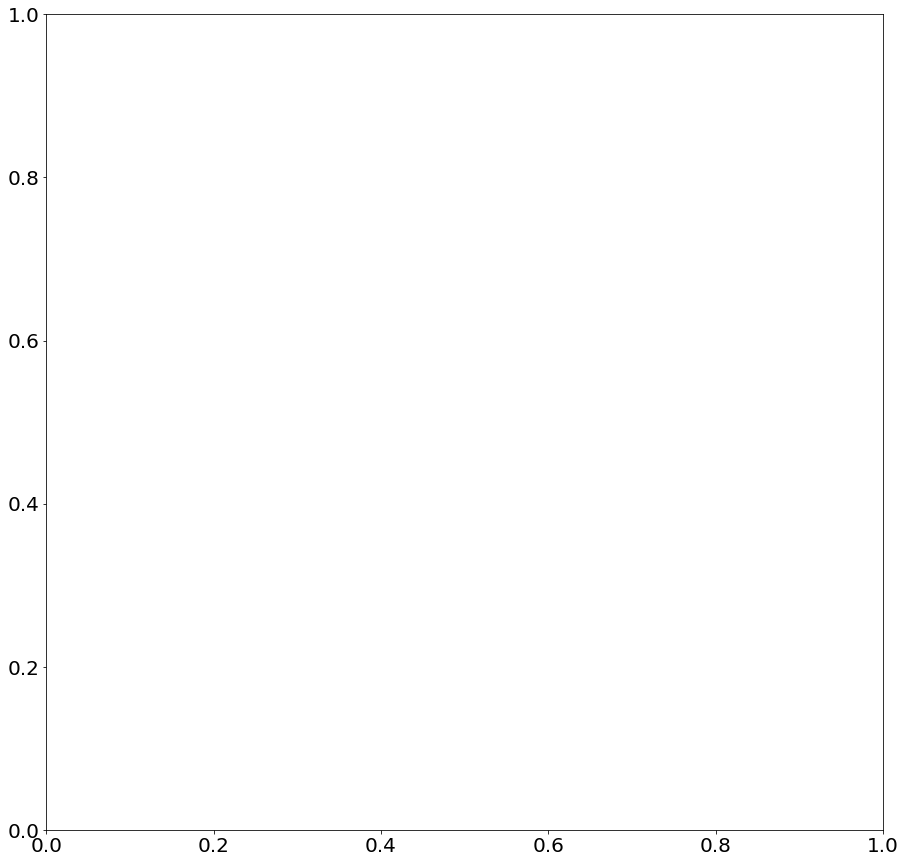

In [ ]:
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
axes_obj = create_choropleth_map(gdf=gdf, target_col="spot_num", draw_axes=axes_obj)

In [ ]:
def compute_global_moran_i_statistic(
    gdf: gpd.GeoDataFrame, spatial_weight_matrix: weights.KNN, target_col: str, plot: bool
) -> esda.moran.Moran:
    moran_i_obj = esda.moran.Moran(y=gdf[target_col], w=spatial_weight_matrix)
    if plot:
        fig_obj, axes_obj = plot_moran(moran=moran_i_obj)
        fig_obj.savefig("japanmap_globalmoran.jpg")

    return moran_i_obj

def global_moran(gdf, target_col,k=8, plot=False):
    spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=k)
    spatial_weight_matrix.transform = "R"
    global_moran_obj = compute_global_moran_i_statistic(gdf, spatial_weight_matrix, target_col, plot=plot)
    print(f"[LOG] moran i statistic: {global_moran_obj.I}")
    print(f"[LOG] empirical p-value: {global_moran_obj.p_sim}")

[LOG] moran i statistic: 0.2089913305923336
[LOG] empirical p-value: 0.001


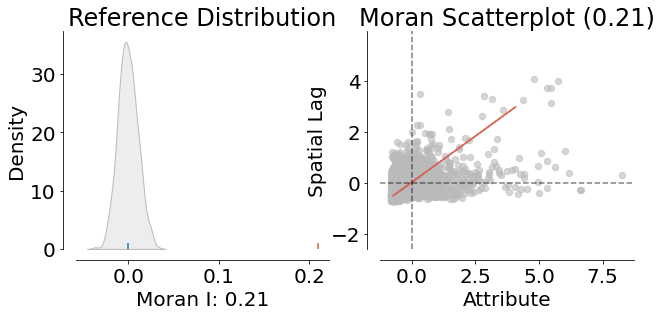

In [ ]:
global_moran(gdf, 'spot_num', plot=True)

In [ ]:
global_moran(gdf_exp, 'review_count', k=10)

[LOG] moran i statistic: 0.06458300772599881
[LOG] empirical p-value: 0.001


In [ ]:
global_moran(gdf, 'review_count'

NameError: name 'gdf' is not defined

In [ ]:
def compute_local_moran_i(gdf: gpd.GeoDataFrame, spatial_weight_matrix: weights.KNN, target_col: str, plot=False):

    local_moran_i_obj = esda.moran.Moran_Local(y=gdf[target_col], w=spatial_weight_matrix)

    return local_moran_i_obj


def local_moran(gdf, target_col, k=8, plot=False):
    spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=k)
    spatial_weight_matrix.transform = "R"
    local_moran_obj = compute_local_moran_i(gdf=gdf, spatial_weight_matrix=spatial_weight_matrix, target_col=target_col, plot=plot)
    print(f"[LOG] moran i statistic: {local_moran_obj.Is}")
    print(f"[LOG] empirical p-value: {local_moran_obj.p_sim}")

In [ ]:
local_moran(gdf, 'spot_num')

[LOG] moran i statistic: [-0.69134667  0.07320102  0.097398   ...  3.44448761  0.20293658
 -0.37794839]
[LOG] empirical p-value: [0.115 0.218 0.375 ... 0.005 0.001 0.088]


In [ ]:
local_moran(gdf_exp, 'review_count', k=10)

[LOG] moran i statistic: [ 7.33536371 -2.60093841  1.572268   ...  0.03842406  0.05856148
  0.04440553]
[LOG] empirical p-value: [0.078 0.268 0.122 ... 0.354 0.071 0.27 ]


In [ ]:
DEFAULT_CRS=4326
class ChoroplethMapLISA:
    def create_local_moran_i_choropleth_maps(self, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local):
        gdf = gdf.to_crs(crs=DEFAULT_CRS)

        fig_obj, axes_obj = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

        axes_obj = axes_obj.flatten()  # Make the axes accessible with single indexing

        axes_obj[0] = self._choropleth_local_statistic(axes_obj[0], gdf, local_moran_obj)
        axes_obj[1] = self._choropleth_quadrant_categories(axes_obj[1], gdf, local_moran_obj)
        axes_obj[2] = self._choropleth_significance_map(axes_obj[2], gdf, local_moran_obj)
        axes_obj[3] = self._choropleth_cluster_map(axes_obj[3], gdf, local_moran_obj)

        fig_obj.tight_layout()
        fig_obj.savefig("local_moran_i_choropleth_maps.jpg")

    def create_local_moran_i_choropleth_maps_p(self, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local):
        gdf = gdf.to_crs(crs=DEFAULT_CRS)

        fig_obj, axes_obj = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

        axes_obj = axes_obj.flatten()  # Make the axes accessible with single indexing

        axes_obj[0] = self._choropleth_cluster_map(axes_obj[0], gdf, local_moran_obj)

        fig_obj.tight_layout()
        fig_obj.savefig("local_moran_i_choropleth_maps.jpg")

    def _choropleth_local_statistic(
        self, axes_obj: Axes, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local
    ) -> Axes:
        df_temp = gdf.assign(Is=local_moran_obj.Is)
        axes_obj = df_temp.plot(
            column="Is",
            cmap="plasma",
            scheme="quantiles",
            k=5,
            edgecolor="white",
            linewidth=0.1,
            alpha=0.75,
            legend=True,
            ax=axes_obj,
        )
        axes_obj = self._arrange_axis_obj(axes_obj, "local_moran_i_statistic")
        return axes_obj

    def _choropleth_quadrant_categories(
        self, axes_obj: Axes, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local
    ) -> Axes:
        lisa_cluster(moran_loc=local_moran_obj, gdf=gdf, p=1, ax=axes_obj)  # 有意水準の設定(1に設定すると全てのObservationが有意として扱われる)
        axes_obj = self._arrange_axis_obj(axes_obj, "scatterplot_quadrant")
        return axes_obj

    def _choropleth_significance_map(
        self, axes_obj: Axes, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local
    ) -> Axes:
        # Recode 1 to "Significant and 0 to "Non-significant"
        significance_dammy_val_series = pd.Series(
            data=1 * (local_moran_obj.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
            index=gdf.index,  # Use the index in the original data
        )
        df_temp = gdf.assign(significance_dammy=significance_dammy_val_series)
        axes_obj = df_temp.plot(
            column="significance_dammy",
            categorical=True,
            k=2,
            cmap="Paired",
            linewidth=0.1,
            edgecolor="white",
            legend=True,
            ax=axes_obj,
        )

        axes_obj = self._arrange_axis_obj(axes_obj, "statistical_significance")

        return axes_obj

    def _choropleth_cluster_map(
        self, axes_obj: Axes, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local
    ) -> Axes:
        lisa_cluster(moran_loc=local_moran_obj, gdf=gdf, p=0.05, ax=axes_obj)

        axes_obj = self._arrange_axis_obj(axes_obj, "moran_cluster_map")

        return axes_obj

    def _arrange_axis_obj(self, axes_obj: Axes, axes_title: str) -> Axes:
        axes_obj.set_axis_off()
        axes_obj.set_title(label=axes_title)

        contextily.add_basemap(
            ax=axes_obj,
            crs=DEFAULT_CRS,
            source=contextily.providers.Stamen.TerrainBackground,
        )
        return axes_obj

def LocalMoranMap(gdf, target_col, save=False):
    # 略
    spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=8)
    spatial_weight_matrix.transform = "R"
    local_moran_obj = compute_local_moran_i(gdf=gdf, spatial_weight_matrix=spatial_weight_matrix, target_col=target_col)
    choropleth_obj = ChoroplethMapLISA()
    fig_obj = choropleth_obj.create_local_moran_i_choropleth_maps(gdf, local_moran_obj)

def LocalMoranMap_p(gdf, target_col, save=False):
    # 略
    spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=8)
    spatial_weight_matrix.transform = "R"
    local_moran_obj = compute_local_moran_i(gdf=gdf, spatial_weight_matrix=spatial_weight_matrix, target_col=target_col)
    choropleth_obj = ChoroplethMapLISA()
    fig_obj = choropleth_obj.create_local_moran_i_choropleth_maps_p(gdf, local_moran_obj)

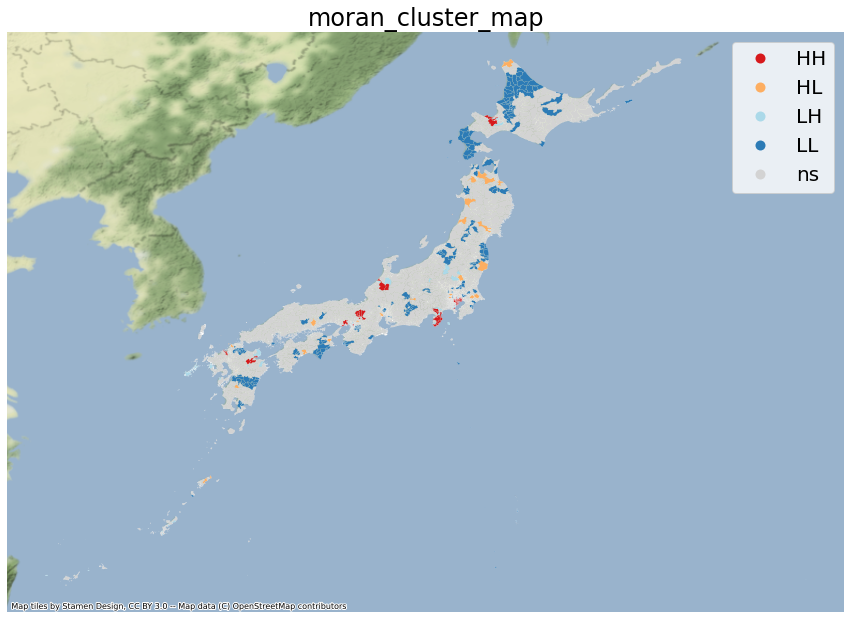

In [ ]:
plt.rcParams['font.size'] = 20
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=8)
spatial_weight_matrix.transform = "R"
local_moran_obj = compute_local_moran_i(gdf=gdf, spatial_weight_matrix=spatial_weight_matrix, target_col='review_count')
choropleth_obj = ChoroplethMapLISA()
axes_obj = choropleth_obj._choropleth_cluster_map(axes_obj, gdf, local_moran_obj)
fig_obj.savefig("japanmap_localmoran.jpg")

In [ ]:
def isin(df):
    return shapely.geometry.Polygon([(122,20),(154,20),(154, 46), (122,46)]).contains(df['geometry'])
gdf_exp['isin'] = gdf_exp.progress_apply(isin, axis=1)

100%|██████████| 42852/42852 [00:05<00:00, 8395.02it/s] 


In [ ]:
gdf_exp = gdf_exp[gdf_exp['isin']==True]
len(gdf_exp)

42851

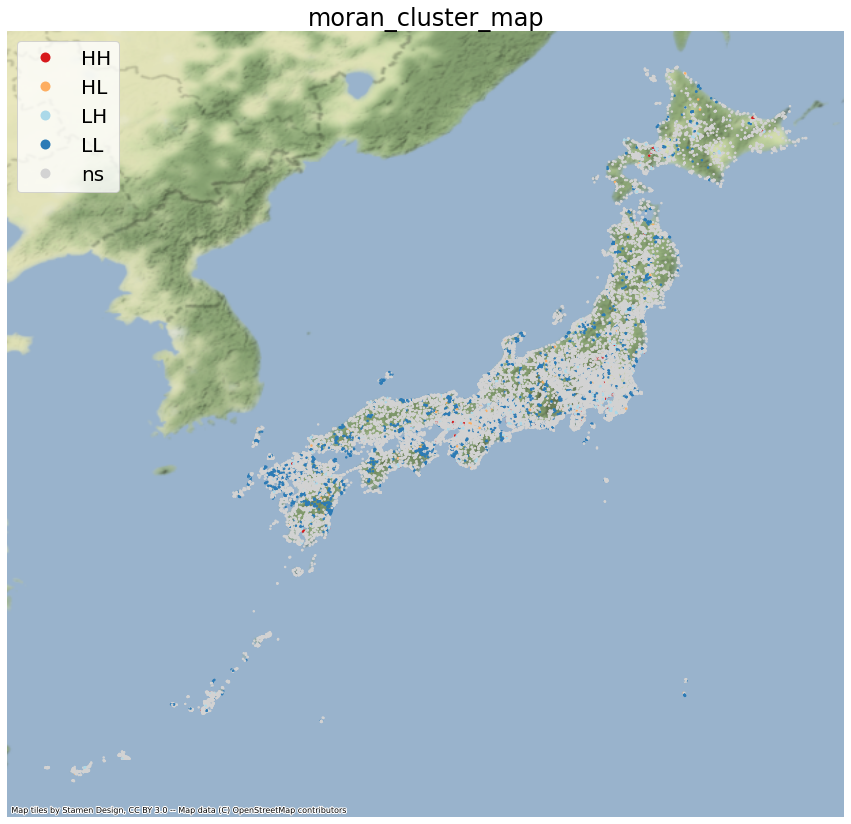

In [ ]:
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 1
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf_exp, k=8)
spatial_weight_matrix.transform = "R"
local_moran_obj = compute_local_moran_i(gdf=gdf_exp, spatial_weight_matrix=spatial_weight_matrix, target_col='review_count')
choropleth_obj = ChoroplethMapLISA()
axes_obj = choropleth_obj._choropleth_cluster_map(axes_obj, gdf_exp, local_moran_obj)
fig_obj.savefig("japanmap_localmoran_spot.jpg")

MLASK

In [ ]:
df_review = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/review/review_all_period_.csv')

In [ ]:
print(len(df_review))
df_review_ = df_review.drop_duplicates()
print(len(df_review_))

3558387
3558387


In [ ]:
from mlask import MLAsk
emotion_analyzer = MLAsk()

In [ ]:
import pandas as pd
import glob
import mlask
from tqdm import tqdm

emotion_lists = []
num=0
for text in tqdm(df_review['review']):
    num+=1
    emotion_list = []
    try:
        res = emotion_analyzer.analyze(text)
    #     print(res)
        try:
            t = res['emotion']['odoroki']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['kowa']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['yasu']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['yorokobi']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['iya']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['aware']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['haji']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['ikari']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['suki']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['takaburi']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        emotion_lists.append(emotion_list)
    except:
        emotion_lists.append([[],[],[],[],[],[],[],[],[],[]])
        print(text)


emotion_df = pd.DataFrame(emotion_lists, columns=['aware', 'haji', 'ikari', 'iya', 'kowa', 'odoroki', 'suki', 'takaburi', 'yasu', 'yorokobi'])
print(emotion_df)

100%|██████████| 3565959/3565959 [1:19:33<00:00, 746.99it/s] 


         aware haji             ikari                iya  kowa odoroki suki  \
0           []   []              [余裕]                 []    []      []   []   
1           []   []                []               [喜ぶ]    []      []   []   
2           []   []                []                 []    []      []   []   
3           []   []                []                 []    []      []   []   
4           []   []                []                 []    []      []   []   
...        ...  ...               ...                ...   ...     ...  ...   
3565954     []   []  [不安*CVS, 安心, 親切]               [丁寧]    []      []   []   
3565955     []   []              [安心]  [丁寧, 楽しい, 満足, 笑い]  [大変]      []   []   
3565956     []   []          [安心, 親切]                 []  [大変]      []   []   
3565957  [予想外]   []                []         [楽しい, 楽しむ]    []      []   []   
3565958     []   []              [親切]               [満足]    []      []   []   

        takaburi            yasu yorokobi  
0      

In [ ]:
emotion_df.to_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/emotion.csv')

In [ ]:
emotion_df = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/emotion.csv')

形容詞

In [ ]:
import MeCab
tokenizer = MeCab.Tagger()
tokenizer.parse("")

def get_adjective(review):
    node = tokenizer.parseToNode(review)
    keywords = []
    while node:
        #if node.feature.split(",")[0] == u"名詞":
        #    keywords.append(node.surface)
        if node.feature.split(",")[0] == u"形容詞":
            keywords.append(node.feature.split(",")[6])
        #elif node.feature.split(",")[0] == u"動詞":
        #    keywords.append(node.feature.split(",")[6])
        node = node.next
    return keywords

def get_verb(review):
    node = tokenizer.parseToNode(review)
    keywords = []
    while node:
        #if node.feature.split(",")[0] == u"名詞":
        #    keywords.append(node.surface)
        if node.feature.split(",")[0] == u"動詞":
            keywords.append(node.feature.split(",")[6])
        #elif node.feature.split(",")[0] == u"動詞":
        #    keywords.append(node.feature.split(",")[6])
        node = node.next
    return keywords

def get_noun(review):
    node = tokenizer.parseToNode(review)
    keywords = []
    while node:
        #if node.feature.split(",")[0] == u"名詞":
        #    keywords.append(node.surface)
        if node.feature.split(",")[0] == u"名詞":
            keywords.append(node.feature.split(",")[6])
        #elif node.feature.split(",")[0] == u"動詞":
        #    keywords.append(node.feature.split(",")[6])
        node = node.next
    return keywords


ModuleNotFoundError: No module named 'MeCab'

In [ ]:
from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
df_review['noun'] = df_review['review'].parallel_apply(get_noun)
df_review['verb'] = df_review['review'].parallel_apply(get_verb)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
tqdm.pandas()
df_review['adjective'] = df_review['review'].parallel_apply(get_adjective)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
df_review['verb']

0          [持つ, 行く, 撮る, 持つ, いる, 入る, 撮る, できる, する, くださる, 思う...
1          [行く, 張り切る, 出かける, 乗る, する, なくなる, しまう, あきらめる, 戻る,...
2           [登る, 認める, いる, 恵まれる, 歩く, 登る, いる, いく, できる, 持つ, 望む]
3                                               [ある, 置く, 登る]
4                  [行ける, 狭める, なる, いる, 開ける, 照らす, れる, 伺う, 過ごす]
                                 ...                        
3565954    [する, する, いただく, 迎える, できる, する, れる, いる, 高まる, いただく...
3565955    [いる, 取れる, 誘う, れる, する, する, れる, 知る, 教える, もらう, する...
3565956    [できる, する, いただける, 向かう, 泳ぐ, できる, する, 楽しめる, する, い...
3565957    [なる, 楽しめる, する, 頂く, なる, 合わせる, 楽しむ, する, 頂く, する, ...
3565958                               [する, する, いただく, する, 行く]
Name: verb, Length: 3565959, dtype: object

GinZa

In [ ]:
df_review

NameError: name 'df_review' is not defined

都道府県ごととカテゴリごとの相関

In [ ]:
df_exp['index'] = df_exp['Unnamed: 0']

In [ ]:
valid_idx = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/valid_idx.npy')
test_result = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/test_result.csv')
test_result['index'] = np.arange(42852)[valid_idx==1]
test_result['spot_name'] = test_result['spot_names']
test_result.head()
test_result = test_result.merge(df_exp, on='index')

In [ ]:
import geopandas as gpd
pref_gdf=gpd.read_file('/home/yamanishi/project/trip_recommend/model/popularity_final/data/prefectures.geojson')

In [ ]:
pref_cor = [0]*47
for i,pref in enumerate(pref_gdf['name']):
    test_result_tmp = test_result[test_result['prefecture']==pref]
    cor = np.corrcoef(test_result_tmp['pred'], test_result_tmp['gt'])
    pref_cor[i] = cor[0][1]

pref_gdf['cor'] = np.array(pref_cor)

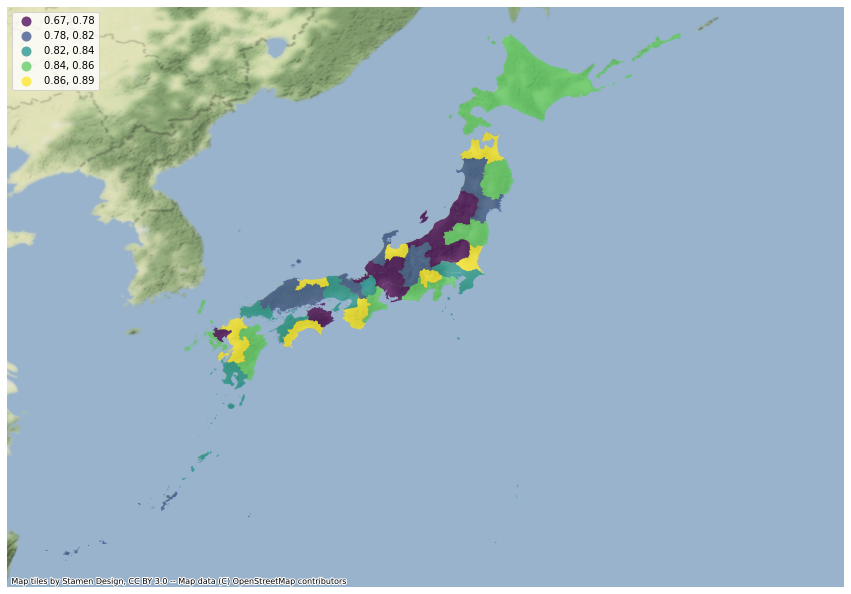

In [ ]:
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
axes_obj = create_choropleth_map(gdf=pref_gdf, target_col="cor", draw_axes=axes_obj)
fig_obj.savefig('japan_cor.png')

In [ ]:
for name, cor in zip(pref_gdf['name'], pref_gdf['cor']):
    print(name, cor)

北海道 0.8368128029078239
青森県 0.8635113186278943
岩手県 0.8500904810662452
宮城県 0.818549566206648
秋田県 0.8077129031500085
山形県 0.7536536436284034
福島県 0.8437804796210162
茨城県 0.8704604382704899
栃木県 0.7802110224616716
群馬県 0.7552448770105179
埼玉県 0.8347999888055909
千葉県 0.824077607607609
東京都 0.8251225608946242
神奈川県 0.8457025334272947
新潟県 0.7834699338241766
富山県 0.8867043059461932
石川県 0.8031410289713805
福井県 0.7527302329452518
山梨県 0.8599916418583103
長野県 0.8008586749433155
岐阜県 0.7717182479978899
静岡県 0.8494525484404691
愛知県 0.714129288898541
三重県 0.8380112720628526
滋賀県 0.8241354062196543
京都府 0.8205098991260046
大阪府 0.828058062034229
兵庫県 0.8264782569640599
奈良県 0.8674005705675756
和歌山県 0.8601792480583877
鳥取県 0.8747918493354455
島根県 0.8171239873685233
岡山県 0.794330107640914
広島県 0.8029093150518731
山口県 0.8235906526100182
徳島県 0.6725652303951024
香川県 0.7123596934130044
愛媛県 0.8235374647729535
高知県 0.8616493030835036
福岡県 0.8809129376464797
佐賀県 0.7641826133722572
長崎県 0.8382253936942884
熊本県 0.8629786554119928
大分県 0.84310518

In [ ]:
overes = []
underes = []
for spot_name, pref, gt, pred in zip(test_result['spot_names'], test_result['prefecture'], test_result['gt'], test_result['pred']):
    if gt-pred>1:
        underes.append((gt-pred, spot_name, pref, round(gt,3), round(pred,3)))

    elif pred-gt>1:
        overes.append((pred-gt, spot_name, pref, round(gt,3), round(pred,3)))

underes.sort(reverse=True)
overes.sort(reverse=True)
print(underes)
print(overes)

[(2.0140808999999997, 'えびせんべいの里\u3000美浜本店', '愛知県', 3.386, 1.372), (1.7367048, '高山陣屋', '岐阜県', 2.911, 1.174), (1.5082503, '大王わさび農場', '長野県', 3.173, 1.665), (1.4617456, '桜島', '鹿児島県', 3.343, 1.881), (1.44550445, '鴨池運動公園', '鹿児島県', 2.382, 0.937), (1.4243764999999997, '掛川花鳥園', '静岡県', 2.974, 1.55), (1.4238411, 'マックスアウトドアツアーズ水上', '群馬県', 3.015, 1.592), (1.4233183, '九十九島パールシーリゾート', '長崎県', 3.025, 1.602), (1.3943406999999999, 'おかげ横丁', '三重県', 3.666, 2.271), (1.3910930000000001, 'aisorashi-アイソラシ', '石川県', 3.563, 2.172), (1.3851485, '六義園', '東京都', 2.954, 1.569), (1.3272308000000002, '蒜山高原', '岡山県', 2.799, 1.471), (1.2962262999999998, '旭山動物園', '北海道', 3.649, 2.353), (1.2440532000000002, '熱海城', '静岡県', 3.041, 1.797), (1.2348979999999998, '鹽竈神社', '宮城県', 2.665, 1.43), (1.1937475, 'ブルーウィングもじ', '福岡県', 2.386, 1.192), (1.1792033000000002, '第１番札所霊山寺', '徳島県', 2.164, 0.985), (1.1783435999999998, '然別湖', '北海道', 2.562, 1.384), (1.1605502, 'えびす屋嵐山總本店', '京都府', 2.56, 1.399), (1.1431408, '川崎市藤子・Ｆ・不二雄ミュージアム', '神奈川県', 2.911, 1

In [ ]:
def tex(i):
    _, spot, pref, gt, pred = underes[i]
    text=''
    text+=spot
    text+=f' ({pref})&'
    text+=f' {gt}&'
    text+=f' {pred}& &'
    _, spot, pref, gt, pred = overes[i]
    text+=spot
    text+=f' ({pref})&'
    text+=f' {gt}&'
    text+=f' {pred}\\\\' 
    return text

print(tex(0))

えびせんべいの里　美浜本店 (愛知県)& 3.386& 1.372& &旧石巻ハリストス正教会教会堂 (宮城県)& 0.845& 2.114\\


In [ ]:
len(overes)

6

In [ ]:
text = ''
for i in range(6):
    text+=tex(i)
    text+='\n'

print(text)

えびせんべいの里　美浜本店 (愛知県)& 3.386& 1.372& &旧石巻ハリストス正教会教会堂 (宮城県)& 0.845& 2.114\\
高山陣屋 (岐阜県)& 2.911& 1.174& &道の駅 キララ多岐 (島根県)& 0.903& 2.13\\
大王わさび農場 (長野県)& 3.173& 1.665& &美崎御嶽 (沖縄県)& 1.398& 2.55\\
桜島 (鹿児島県)& 3.343& 1.881& &千尋岩 (東京都)& 0.845& 1.954\\
鴨池運動公園 (鹿児島県)& 2.382& 0.937& &新潟市新津美術館 (新潟県)& 1.176& 2.204\\
掛川花鳥園 (静岡県)& 2.974& 1.55& &プラン・ド・ヴェール (神奈川県)& 1.0& 2.018\\



In [ ]:
tfidf_words[df_exp[df_exp['spot_name'].str.contains('えびせんべいの里')].index.values]

array([['試食', 'せんべい', 'えび', 'コーヒー', 'せん', 'お茶', '土産', '対策', 'トング', '工場',
        '無料', 'コーナー', '煎餅', '知多', '種類']], dtype='<U22')

In [ ]:
tfidf_words[20152]

array(['陣屋', '高山', '朝市', '宮川', '代官', 'スリッパ', '幕府', '飛騨', '役所', '歴史', '江戸',
       '直轄', '床の間', '郡代', '書院'], dtype='<U22')

In [ ]:
with open('/home/yamanishi/project/trip_recommend/data/jalan/graph/category_index.pkl', 'rb') as f:
    category_index = pickle.load(f)
category = category_index.keys()
category = list(category)

In [ ]:
def jenre_cor(text):
    contain = [False]*len(test_result)
    for i,j in enumerate(test_result['jenre']):
        j = j.split(',')
        if text in j:
            contain[i] = True
    pred = test_result['pred'][contain]
    gt = test_result['gt'][contain]
    cor = np.corrcoef(pred, gt)[0][1]
    return cor, contain.count(True)
jenre_cor(category[0])

(0.8316547509111218, 446)

In [ ]:
for i in range(len(category)):
     cor, cont = jenre_cor(category[i])
     if cont>=10:
          print(category[i], cor, cont)

自然景観・絶景 0.8316547509111218 446
山岳 0.8204273471383745 93
観光施設・名所巡り 0.8408214672484827 1351
動物園・植物園 0.8755468872269462 279
ショッピング 0.8188463242121168 141
その他ショッピング 0.8037683135280488 97
海岸景観 0.8415686615071775 82
果物・野菜狩り 0.7612537325913178 113
ぶどう狩り 0.74474286459677 12
その他果物・野菜狩り 0.9296080161574544 13
乗り物 0.8428296924367507 154
クルーズ・クルージング 0.7821627338103287 23
湖沼 0.8328007036776617 39
神社・神宮・寺院 0.8128831328953555 471
その他神社・神宮・寺院 0.816724607156011 445
公園・庭園 0.8175708366310593 276
エンタメ・アミューズメント 0.7997224814261127 48
テーマパーク・レジャーランド 0.8204603079342989 20
その他 0.7990347983105335 209
その他名所 0.811619307011218 178
ミュージアム・ギャラリー 0.8067603914265559 315
博物館 0.8366788648410353 182
産業観光施設 0.7979104867972355 41
展望台・展望施設 0.877036212859895 78
運河・河川景観 0.886516424444015 81
歴史的建造物 0.7274124198847758 133
町並み 0.8472803628931295 31
町めぐり・食べ歩き 0.9585054366079205 10
風呂・スパ・サロン 0.7968074213909149 345
日帰り温泉 0.7701638790953829 123
高原 0.6678231026352811 16
ショッピングセンター 0.8179366048300708 11
特殊地形 0.7763198323947991 30
雪・スノー

In [ ]:
df_result = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity/result/result.csv', names=['cor', 'best_epoch', 'model', 'layer_num', 'lr', 'hidden_channels', 'concat', 'city_pop', 'word', 'category', 'city', 'pref'])[190:]
df_result.head()

,cor,best_epoch,model,layer_num,lr,hidden_channels,concat,city_pop,word,category,city,pref
190,0.77039,339,ggnn,4,0.0001,384,False,0.0,True,False,False,False
191,0.48736,339,ggnn,4,0.0001,384,False,0.0,False,True,False,False
192,0.47231,349,ggnn,4,0.0001,384,False,0.0,False,False,True,True
193,0.81382,309,ggnn,4,0.0001,384,False,0.0,True,True,True,True
194,0.28928,4,ggnn,4,0.0001,128,False,0.0,True,True,True,True


In [ ]:
df_result[(df_result['model']=='sage')&(df_result['layer_num']==3)&(df_result['hidden_channels']==256)]

,cor,best_epoch,model,layer_num,lr,hidden_channels,concat,city_pop,word,category,city,pref
261,0.77902,92,sage,3,0.0005,256,False,0.0,True,False,False,False
262,0.79445,103,sage,3,0.0005,256,False,0.0,True,True,False,False
263,0.79643,102,sage,3,0.0005,256,False,0.0,True,True,True,False
264,0.80119,88,sage,3,0.0005,256,False,0.0,True,True,True,True


In [ ]:
df_ggnn = df_result[df_result['model']=='ggnn']
sage = []
gcn = []
hgt = []
han = []
ggnn = []
for cor, layer_num, hidden_channels in zip(df['cor'], df_ggnn['layer_num'], df_ggnn['hidden_channels']):
    

0.77039 4 384
0.48736 4 384
0.47231 4 384
0.81382 4 384
0.28928 4 128
0.74874 1 32
0.77082 1 64
0.77593 1 128
0.78441 1 256
0.7934 1 384
0.79456 1 512
0.78665 2 32
0.80051 2 64
0.79718 2 128
0.81313 2 256
0.81058 2 384
0.81187 2 512
0.78281 3 32
0.80664 3 128
0.7973 3 64
0.80864 3 128
0.80421 3 128
0.81197 3 128
0.80717 3 256
0.81262 3 128
0.8176 3 384
0.82382 3 512
0.77815 4 32
0.7989 4 64
0.80431 4 128
0.81626 4 256
0.81551 4 384
0.8193 4 512
0.77198 5 32
0.7898 5 64
0.80608 5 128
0.81507 5 256
0.81067 5 384
0.81823 5 512
0.81154 3 256
0.81299 3 256
0.8157 3 256
0.81844 3 256


In [ ]:
layer_num = [1,2,3,4,5]
cor = [0.794, ]

basm

場所ごとのtfidf

In [ ]:
df_exp = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
tfidf_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_words.npy')
tfidf_topk_index = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_topk_index.npy')
tfidf_top_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')

In [ ]:
spot_city = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/spot_city.npy')

In [ ]:
city_attr = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/city_attr_cat.npy')

In [ ]:
city_words = [[] for _ in range(1709)]
for i,words in tqdm(enumerate(tfidf_top_words)):
    for word in words:
        city_words[spot_city[1][i]].append(word)

42852it [00:00, 55391.90it/s]


In [ ]:
city_words = [(' ').join(i) for i in city_words]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10,max_df=0.5)
tfidf_vec = tfidf.fit_transform(city_words).toarray()
print(tfidf_vec.shape)
feature_names = np.array(tfidf.get_feature_names())
k=50
inds = []
for i in range(len(city_words)):
    inds.append(np.argsort(-tfidf_vec[i])[:k])
print(len(inds))
city_tfidf_top_words = []
for i,ind in enumerate(inds):
    city_tfidf_top_words.append(feature_names[np.array(ind)])

(1709, 7509)
1709


In [ ]:
spot_pref = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/spot_pref.npy')
pref_words = [[] for _ in range(47)]
for i,words in tqdm(enumerate(tfidf_top_words)):
    for word in words:
        pref_words[spot_pref[1][i]].append(word)
pref_words = [(' ').join(i) for i in pref_words]

42852it [00:00, 51095.61it/s]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10,max_df=0.5)
tfidf_vec = tfidf.fit_transform(pref_words).toarray()
print(tfidf_vec.shape)
feature_names = np.array(tfidf.get_feature_names())
k=200
inds = []
for i in range(len(pref_words)):
    inds.append(np.argsort(-tfidf_vec[i])[:k])
print(len(inds))
pref_tfidf_top_words = []
for i,ind in enumerate(inds):
    pref_tfidf_top_words.append(feature_names[np.array(ind)])

(47, 4173)
47


In [ ]:
import torch
cities = []
words_to = []
for city, words in enumerate(city_tfidf_top_words):
    for word in words:
        index =  words_index[word]
        cities.append(city)
        words_to.append(index)
city_words = torch.tensor([cities, words_to])
torch.save(city_words,'/home/yamanishi/project/trip_recommend/data/jalan/graph/city_words.pt')

In [ ]:
import torch
prefs = []
words_to = []
for pref, words in enumerate(pref_tfidf_top_words):
    for word in words:
        index =  words_index[word]
        prefs.append(pref)
        words_to.append(index)
pref_words = torch.tensor([prefs, words_to])
torch.save(pref_words,'/home/yamanishi/project/trip_recommend/data/jalan/graph/pref_words.pt')

In [ ]:
torch.randint(0, 66000, size=(10,))

tensor([58605,  2190, 41591, 58645, 55862, 34724, 30345,  5256,  9168, 22763])

In [ ]:
np.random.choice(np.arange(100),50, replace=False)

array([ 8, 34, 92, 45, 78, 24, 39, 84, 49, 97, 35, 93,  0, 38, 86, 51,  7,
       53, 67, 90, 46, 42, 77, 37, 26, 16,  3, 87, 17, 28, 85, 10,  4, 14,
       44, 18, 65, 83, 60,  6, 74, 21, 40, 69, 54, 36, 13, 29, 48, 99])

In [ ]:
cities

[0]

In [ ]:
city_from = []

In [ ]:
city_words[0]

[45732,
 30565,
 33715,
 63401,
 44071,
 20940,
 35359,
 22744,
 19577,
 12253,
 5552,
 53611,
 34704,
 66778,
 31298,
 27566,
 38885,
 34514,
 43801,
 21267]

In [ ]:
city_words[2]

[37693,
 63490,
 54351,
 12896,
 13583,
 30565,
 13578,
 49050,
 58217,
 45732,
 12636,
 13718,
 63401,
 27774,
 12258,
 15689,
 17814,
 29812,
 27430,
 48160]